In [20]:
## Read data
from pathlib import Path
import pandas as pd
import seaborn as sns
out_dir = Path("/output")
mni_file = out_dir/'freesurfer_out_preped.csv'
ppmi_file = out_dir/'data'/'ppmi'/'NC_PPMI'/'3T_T1_NC_5_08_2021.csv'

#reading and filtering to get age and sex of 
mni_tab  = pd.read_csv(mni_file, sep=',', header=0, index_col=0)
mni_nc_tab  = mni_tab[mni_tab['diagnosis']=='NC'][['age','sex']]; mni_nc_tab['group']='MNI NC'
mni_et_tab  = mni_tab[mni_tab['diagnosis']=='ET'][['age','sex']]; mni_et_tab['group']='MNI ET'
ppmi_tab = pd.read_csv(ppmi_file, sep=',', header=0, index_col=0)
display(ppmi_tab)
# take the first visit
ppmi_tab1 = ppmi_tab[ppmi_tab['Visit']==1]
ppmi_nc_tab  = ppmi_tab1[['Age','Sex']]
ppmi_nc_tab = ppmi_nc_tab.rename(columns=str.lower); ppmi_nc_tab['group']='PPMI NC'
data_tab = pd.concat([mni_et_tab, mni_nc_tab, ppmi_nc_tab])
# check visits
# 1. unique subjects with latest visits;
# 2. check aquisitions;
# 3. matching

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
Image Data ID,,,,,,,,,,,
I377984,4139,Control,M,81,1,MRI,MPRAGE GRAPPA,Original,4/09/2013,DCM,NaN
I1044937,4085,Control,M,72,1,MRI,MPRAGE GRAPPA,Original,5/14/2018,DCM,NaN
I864811,4085,Control,M,71,11,MRI,MPRAGE GRAPPA2,Original,3/20/2017,DCM,NaN
I1044936,4085,Control,M,72,1,MRI,MPRAGE GRAPPA2,Original,5/14/2018,DCM,NaN
I377941,4085,Control,M,67,1,MRI,MPRAGE GRAPPA,Original,4/08/2013,DCM,NaN
I864810,4085,Control,M,71,11,MRI,MPRAGE GRAPPA2,Original,3/20/2017,DCM,NaN
I507833,4085,Control,M,69,7,MRI,MPRAGE GRAPPA,Original,6/01/2015,DCM,NaN
I864812,4085,Control,M,71,11,MRI,MPRAGE GRAPPA,Original,3/20/2017,DCM,NaN
I356067,4067,Control,M,62,1,MRI,MPRAGE GRAPPA,Original,12/21/2012,DCM,NaN


MNI ET Male/Female:  28 / 10  in  38
MNI NC Male/Female:  21 / 11  in  32
PPMI NC Male/Female:  77 / 39  in  116
Group age mean:


,age
group,
MNI ET,73.394737
MNI NC,56.312500
PPMI NC,60.232759


Group age standard deviation:


,age
group,
MNI ET,6.965317
MNI NC,11.093263
PPMI NC,11.264687


chisqure test for MNI ET and MNI NC sex (chisq, pval):
	Results are:  chisq =0.2220, pvalue = 0.6375
chisqure test for MNI ET and PPMI NC sex (chisq, pval):
	Results are:  chisq =0.4076, pvalue = 0.5232
Independent t test for MNI ET and MNI NC age (tstat, pval, df):
	Results are:  tstat =7.8386, pvalue = 0.0000, df = 68
Independent t test for MNI ET and PPMI NC age (tstat, pval, df):
	Results are:  tstat =6.7818, pvalue = 0.0000, df = 152


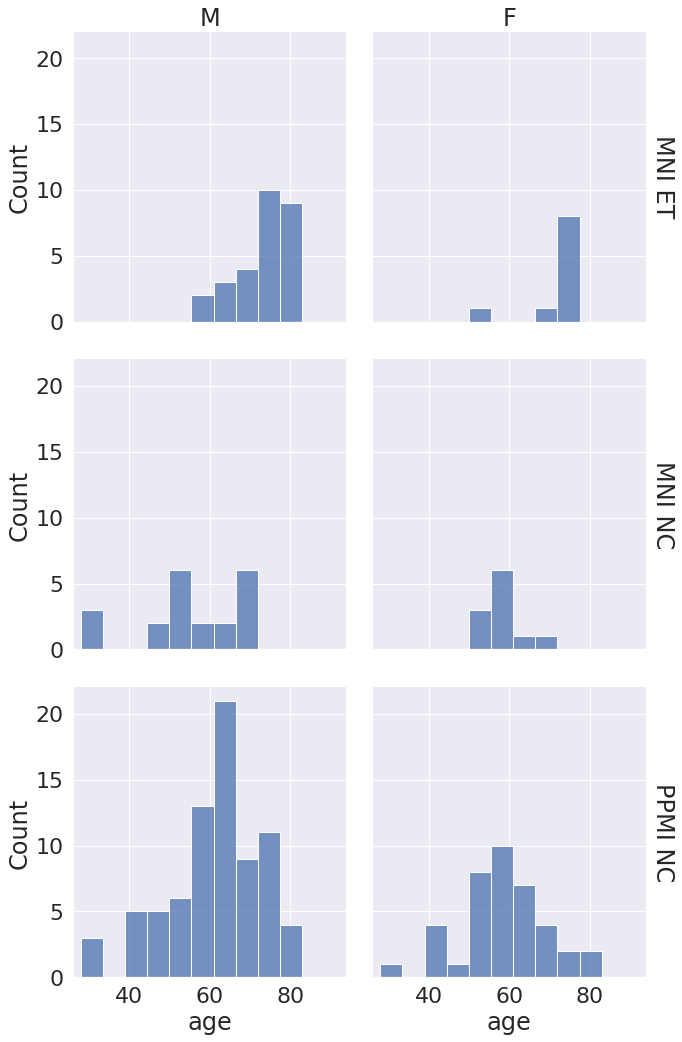

In [2]:
# plot distribution
import matplotlib.pyplot as plt
import scipy
import statsmodels.stats.weightstats as ws
import math
SEX_ORDER=['M','F']; GROUP_ORDER=['MNI ET', 'MNI NC', 'PPMI NC']
LIM_AGE=(26, 94); LIM_CNT=(0, 22); 
# report
# 1. reporrt sex count
mni_et_m=data_tab[(data_tab['group']=='MNI ET')&(data_tab['sex']=='M')].shape[0];
mni_et_f=data_tab[(data_tab['group']=='MNI ET')&(data_tab['sex']=='F')].shape[0];
mni_nc_m=data_tab[(data_tab['group']=='MNI NC')&(data_tab['sex']=='M')].shape[0];
mni_nc_f=data_tab[(data_tab['group']=='MNI NC')&(data_tab['sex']=='F')].shape[0];
ppmi_nc_m=data_tab[(data_tab['group']=='PPMI NC')&(data_tab['sex']=='M')].shape[0];
ppmi_nc_f=data_tab[(data_tab['group']=='PPMI NC')&(data_tab['sex']=='F')].shape[0];
print('MNI ET Male/Female: ' , mni_et_m, '/',  mni_et_f, ' in ', mni_et_m+mni_et_f)
print('MNI NC Male/Female: ' , mni_nc_m, '/',  mni_nc_f, ' in ', mni_nc_m+mni_nc_f)
print('PPMI NC Male/Female: ', ppmi_nc_m, '/', ppmi_nc_f, ' in ',ppmi_nc_m+ppmi_nc_f)
# 2. report age mean and std
print("Group age mean:"); display(data_tab.groupby(['group']).mean())
print("Group age standard deviation:");display(data_tab.groupby(['group']).std())

# 3.1 chi2 tests for MNI dataset sex
print('chisqure test for MNI ET and MNI NC sex (chisq, pval):')
chisq, chi_pval = scipy.stats.chi2_contingency([[mni_et_m, mni_et_f], [mni_nc_m, mni_nc_f]])[:2]
print('\tResults are: ','chisq =%.4f, pvalue = %.4f'%(chisq, chi_pval))

# 3.2 chi2 tests for MNI dataset sex
print('chisqure test for MNI ET and PPMI NC sex (chisq, pval):')
chisq, chi_pval = scipy.stats.chi2_contingency([[mni_et_m, mni_et_f], [ppmi_nc_m, ppmi_nc_f]])[:2]
print('\tResults are: ','chisq =%.4f, pvalue = %.4f'%(chisq, chi_pval))

# 4.1. t tests for age
print('Independent t test for MNI ET and MNI NC age (tstat, pval, df):')
t_stat,t_pval,t_df=ws.ttest_ind(data_tab[data_tab['group']=='MNI ET']['age'], data_tab[data_tab['group']=='MNI NC']['age'],
                                alternative='two-sided', usevar='pooled')
print('\tResults are: ','tstat =%.4f, pvalue = %.4f, df = %i'%(t_stat, t_pval, t_df))

# 4.2. t tests for age
print('Independent t test for MNI ET and PPMI NC age (tstat, pval, df):')
t_stat,t_pval,t_df=ws.ttest_ind(data_tab[data_tab['group']=='MNI ET']['age'], data_tab[data_tab['group']=='PPMI NC']['age'],
                                alternative='two-sided', usevar='pooled')
print('\tResults are: ','tstat =%.4f, pvalue = %.4f, df = %i'%(t_stat, t_pval, t_df))

# plot
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
dist_plt=sns.displot(data_tab, x="age", row="group", col='sex',
                     facet_kws=dict(margin_titles=True),
                     col_order=SEX_ORDER, row_order=GROUP_ORDER)
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")
dist_plt.set(ylim=LIM_CNT); dist_plt.set(xlim=LIM_AGE); 

In [4]:
# matching by percentile
import numpy as np
import math

nc_needed=116; nc_m_needed=round(nc_needed*(mni_et_m/(mni_et_m+mni_et_f))); nc_f_needed=round(nc_needed*(mni_et_f/(mni_et_m+mni_et_f))); 
th_lower = np.percentile(mni_et_tab['age'], 5); th_higher = np.percentile(mni_et_tab['age'],95); 
th_min = min(mni_et_tab['age']); th_max = max(mni_et_tab['age']);
# put NCs together
nc_tab = pd.concat([mni_nc_tab, ppmi_nc_tab])
print('total number of NCs: ', len(nc_tab), ', targeted number of NCs: ', nc_needed, ', targed M: ', nc_m_needed, ', targeted F: ', nc_f_needed,'\n')

#1. blind matching for 5%-95% of ET percentile neglecting sex
ppmic_nc_sel=ppmi_nc_tab[(ppmi_nc_tab['age']>=th_lower)&(ppmi_nc_tab['age']<=th_higher)];
print('PPMI NC within 5-95%: ', len(ppmic_nc_sel))
mni_nc_sel=mni_nc_tab[(mni_nc_tab['age']>=th_lower)&(mni_nc_tab['age']<=th_higher)];
print('MNI NC within 5-95%: ', len(mni_nc_sel))
nc_sel=nc_tab[(nc_tab['age']>=th_lower)&(nc_tab['age']<=th_higher)];
print('All NC within 5-95%: ', len(nc_sel))

ppmic_nc_sel=ppmi_nc_tab[(ppmi_nc_tab['age']>=th_min)&(ppmi_nc_tab['age']<=th_max)];
print('PPMI NC within min-max: ', len(ppmic_nc_sel))
mni_nc_sel=mni_nc_tab[(mni_nc_tab['age']>=th_min)&(mni_nc_tab['age']<=th_max)];
print('MNI NC within min-max: ', len(mni_nc_sel))
nc_sel=nc_tab[(nc_tab['age']>=th_min)&(nc_tab['age']<=th_max)];
print('All NC within min-max: ', len(nc_sel))

#  2. blind matching for 5%-95% of ET percentile by sex
ppmic_nc_m_tab=ppmi_nc_tab[ppmi_nc_tab['sex']=='M']; mni_nc_m_tab=mni_nc_tab[mni_nc_tab['sex']=='M'];  all_nc_m_tab=nc_tab[nc_tab['sex']=='M'];
th_lower_m = np.percentile(mni_et_tab[mni_et_tab['sex']=='M']['age'], 5); th_higher_m = np.percentile(mni_et_tab[mni_et_tab['sex']=='M']['age'],95);
ppmic_nc_m_sel=ppmic_nc_m_tab[(ppmic_nc_m_tab['age']>=th_lower_m)&(ppmic_nc_m_tab['age']<=th_higher_m)];
print('PPMI NC within 5-95% for Male: ', len(ppmic_nc_m_sel))
mni_nc_m_sel=mni_nc_m_tab[(mni_nc_m_tab['age']>=th_lower_m)&(mni_nc_m_tab['age']<=th_higher_m)];
print('MNI NC within 5-95% for Male: ', len(mni_nc_m_sel))
all_nc_m_sel=all_nc_m_tab[(all_nc_m_tab['age']>=th_lower_m)&(all_nc_m_tab['age']<=th_higher_m)];
print('All NC within 5-95% for Male: ', len(all_nc_m_sel))
ppmic_nc_f_tab=ppmi_nc_tab[ppmi_nc_tab['sex']=='F']; mni_nc_f_tab=mni_nc_tab[mni_nc_tab['sex']=='F'];  all_nc_f_tab=nc_tab[nc_tab['sex']=='F'];
th_lower_f = np.percentile(mni_et_tab[mni_et_tab['sex']=='F']['age'], 5); th_higher_f = np.percentile(mni_et_tab[mni_et_tab['sex']=='F']['age'],95);
ppmic_nc_f_sel=ppmic_nc_f_tab[(ppmic_nc_f_tab['age']>=th_lower_f)&(ppmic_nc_f_tab['age']<=th_higher_f)];
print('PPMI NC within 5-95% for Female: ', len(ppmic_nc_f_sel))
mni_nc_f_sel=mni_nc_f_tab[(mni_nc_f_tab['age']>=th_lower_f)&(mni_nc_f_tab['age']<=th_higher_f)];
print('MNI NC within 5-95% for Female: ', len(mni_nc_f_sel))
all_nc_f_sel=all_nc_f_tab[(all_nc_f_tab['age']>=th_lower_f)&(all_nc_f_tab['age']<=th_higher_f)];
print('All NC within 5-95% for Female: ', len(all_nc_f_sel))

total number of NCs:  148 , targeted number of NCs:  116 , targed M:  85 , targeted F:  31 

PPMI NC within 5-95%:  65
MNI NC within 5-95%:  11
All NC within 5-95%:  76
PPMI NC within min-max:  86
MNI NC within min-max:  18
All NC within min-max:  104
PPMI NC within 5-95% for Male:  45
MNI NC within 5-95% for Male:  8
All NC within 5-95% for Male:  53
PPMI NC within 5-95% for Female:  13
MNI NC within 5-95% for Female:  2
All NC within 5-95% for Female:  15


/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Male NC: PPMI->  68 , MNI->  18
Female NC: PPMI->  21 , MNI->  9
chisqure test for MNI ET and augmented NC sex (chisq, pval):
	Results are:  chisq =0.0249, pvalue = 0.8746
Independent t test for MNI ET and augmented NC age (tstat, pval, df):
	Results are:  tstat =9.3516, pvalue = 0.0000, df = 152


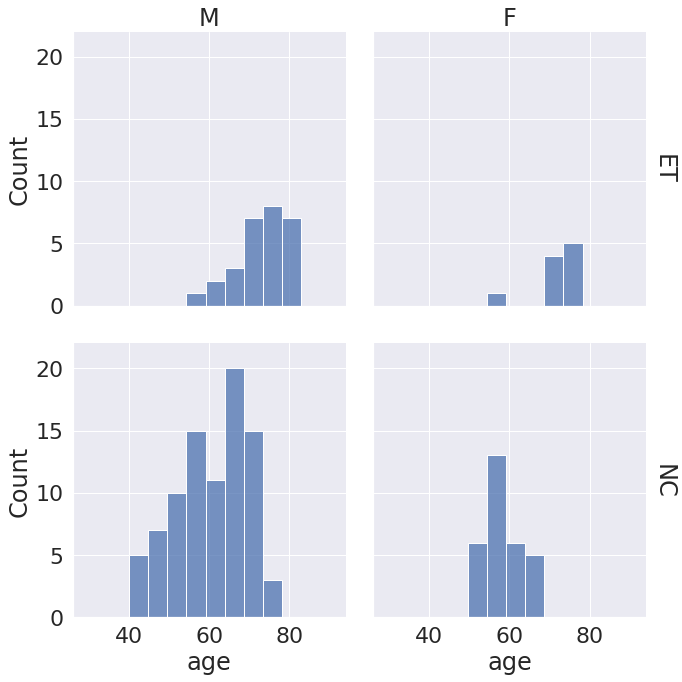

In [5]:
# matching by eliminating the extremes
def age2percentile(age_array):
    import numpy as np
    percentiles = np.argsort(np.argsort(age_array)) * 100. / (len(age_array) - 1)
    return percentiles

# centered on ET mean for each sex
et_m_mean = mni_et_tab[mni_et_tab['sex']=='M']['age'].mean(); et_m_std = mni_et_tab[mni_et_tab['sex']=='M']['age'].std();
et_f_mean = mni_et_tab[mni_et_tab['sex']=='F']['age'].mean(); et_f_std = mni_et_tab[mni_et_tab['sex']=='F']['age'].std(); 
nc_m_tab=nc_tab[nc_tab['sex']=='M']; nc_m_tab['et_score']=(nc_m_tab['age']-et_m_mean)/et_m_std;
nc_f_tab=nc_tab[nc_tab['sex']=='F']; nc_f_tab['et_score']=(nc_f_tab['age']-et_f_mean)/et_f_std;
nc_m_tab['percentile']=age2percentile(nc_m_tab['et_score']); nc_f_tab['percentile']=age2percentile(nc_f_tab['et_score']);

# cal the percentile to preserve and get the threshold
nc_needed=116; nc_m_needed=round(nc_needed*(mni_et_m/(mni_et_m+mni_et_f))); nc_f_needed=round(nc_needed*(mni_et_f/(mni_et_m+mni_et_f)));
n_nc_m=len(nc_m_tab); n_nc_f=len(nc_f_tab); 
th_p_m=math.floor(100*(1-nc_m_needed/n_nc_m)/2); th_p_f=math.floor(100*(1-nc_f_needed/n_nc_f)/2);
nc_m_sel = nc_m_tab[(nc_m_tab['percentile']>th_p_m)&(nc_m_tab['percentile']<100-th_p_m)]
nc_f_sel = nc_f_tab[(nc_f_tab['percentile']>th_p_f)&(nc_f_tab['percentile']<100-th_p_f)]

# final results
fianl_sel = pd.concat([nc_m_sel,nc_f_sel])
print('Male NC: PPMI-> ', len(nc_m_sel[nc_m_sel['group']=='PPMI NC']), ', MNI-> ', len(nc_m_sel[nc_m_sel['group']=='MNI NC']))
print('Female NC: PPMI-> ', len(nc_f_sel[nc_f_sel['group']=='PPMI NC']),', MNI-> ', len(nc_f_sel[nc_f_sel['group']=='MNI NC']))


# t-test and chi-squre test
# chi2 tests for MNI dataset sex
print('chisqure test for MNI ET and augmented NC sex (chisq, pval):')
chisq, chi_pval = scipy.stats.chi2_contingency([[mni_et_m, mni_et_f], [len(nc_m_sel), len(nc_f_sel)]])[:2]
print('\tResults are: ','chisq =%.4f, pvalue = %.4f'%(chisq, chi_pval))

# 4.1. t tests for age
print('Independent t test for MNI ET and augmented NC age (tstat, pval, df):')
t_stat,t_pval,t_df=ws.ttest_ind(data_tab[data_tab['group']=='MNI ET']['age'], fianl_sel['age'],
                                alternative='two-sided', usevar='pooled')
print('\tResults are: ','tstat =%.4f, pvalue = %.4f, df = %i'%(t_stat, t_pval, t_df))

##
fianl_sel['group_new']='NC';  mni_et_tab['group_new']='ET'
final_data=pd.concat([mni_et_tab, fianl_sel])
# plot
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
dist_plt=sns.displot(final_data, x="age", row="group_new", col='sex',
                     facet_kws=dict(margin_titles=True),
                     col_order=SEX_ORDER, row_order=['ET','NC'])
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")
dist_plt.set(ylim=LIM_CNT); dist_plt.set(xlim=LIM_AGE); 

In [11]:
#2. exact matching by discrete distributions, may not applicable ()
# get distribution
vc_et_m=mni_et_tab[mni_et_tab['sex']=='M']['age'].value_counts().to_frame(); vc_et_m['cnt_et']=vc_et_m['age'] ;vc_et_m['age']=vc_et_m.index;
vc_et_f=mni_et_tab[mni_et_tab['sex']=='F']['age'].value_counts().to_frame(); vc_et_f['cnt_et']=vc_et_f['age'] ;vc_et_f['age']=vc_et_f.index;
vc_nc_m=nc_tab[nc_tab['sex']=='M']['age'].value_counts().to_frame(); vc_nc_m['cnt_nc']=vc_nc_m['age'] ;vc_nc_m['age']=vc_nc_m.index;
vc_nc_f=nc_tab[nc_tab['sex']=='F']['age'].value_counts().to_frame(); vc_nc_f['cnt_nc']=vc_nc_f['age'] ;vc_nc_f['age']=vc_nc_f.index;
 
# merge distribution
cnt_m_all=vc_et_m.merge(vc_nc_m, how='outer', left_on='age', right_on='age', sort=1);
cnt_m_all['rate']=cnt_m_all['cnt_nc']/cnt_m_all['cnt_et']

cnt_f_all=vc_et_f.merge(vc_nc_f, how='outer', left_on='age', right_on='age', sort=1);
cnt_f_all['rate']=cnt_f_all['cnt_nc']/cnt_f_all['cnt_et']

#display(cnt_m_all)
display(cnt_f_all)

,age,cnt_et,cnt_nc,rate
0,32,NaN,1.0,NaN
1,40,NaN,1.0,NaN
2,41,NaN,1.0,NaN
3,42,NaN,2.0,NaN
4,49,NaN,1.0,NaN
5,50,NaN,1.0,NaN
6,51,NaN,1.0,NaN
7,53,NaN,5.0,NaN
8,54,NaN,3.0,NaN
9,55,1.0,1.0,1.000000


In [19]:
# matching by span of age (10 years)
BIN_AGE = [0,40,50,60,70,80,100];
display(pd.cut(mni_et_tab['age'], BIN_AGE).value_counts())
display(pd.cut(mni_nc_tab['age'], BIN_AGE).value_counts())
display(pd.cut(ppmi_nc_tab['age'], BIN_AGE).value_counts())


(70, 80]     23
(80, 100]     7
(60, 70]      5
(50, 60]      3
(40, 50]      0
(0, 40]       0
Name: age, dtype: int64

(50, 60]     17
(60, 70]      7
(70, 80]      3
(0, 40]       3
(40, 50]      2
(80, 100]     0
Name: age, dtype: int64

(60, 70]     39
(50, 60]     36
(70, 80]     18
(40, 50]     13
(0, 40]       7
(80, 100]     3
Name: age, dtype: int64

In [ ]:
# L1 and L2 distance matching
def dist_score_L2(age, group_age):
    group_size = len(group_age);
    score=np.mean(np.power(group_age-age,2))
    return score
